In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "4" # Case 1 is for anomalous density diffusion only.
filepath = "mms" + str(case) + "_n/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("circle_highres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 3GB
Dimensions:             (x: 516, y: 1, z: 516, t: 201)
Coordinates:
    dx                  (x, y, z) float64 2MB dask.array<chunksize=(516, 1, 516), meta=np.ndarray>
    dy                  (x, y, z) float64 2MB dask.array<chunksize=(516, 1, 516), meta=np.ndarray>
    dz                  (x, y, z) float64 2MB dask.array<chunksize=(516, 1, 516), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 4kB 0 1 2 3 4 5 6 ... 510 511 512 513 514 515
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 4kB 0.000969 0.002907 ... 0.9971 0.999
Data variables: (12/52)
    Bxy                 (x, y, z) float64 2MB dask.array<chunksize=(516, 1, 516), meta=np.ndarray>
    G1                  (x, y, z) float64 2MB dask.array<chunksize=(516, 1, 516), meta=np.ndarray>
    G2                  (x, y, z) float64 2MB dask.array<chunksize=(516

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [5]:
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

In [6]:
beta0 = 3.8317059702075125
xc, zc = 1.5, 0.0

x_unit = 0.00022846974366979959 #rho_s0
w_unit = 95788333.030660808    #Omega_ci
t_unit = 1/w_unit

nx = 64*8 #int(case)
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx # centered x
z = (np.arange(nz, dtype=np.float64)) * dz       # unshifted z

xhalf  = np.float64(x[len(x)//2])
zhalf  = np.float64(z[len(z)//2])

xx, zz = np.meshgrid(x,z,indexing='ij',copy=False)
a      = np.float64(0.333333333333)
D      = np.float64(0.2)#/(x_unit*x_unit*w_unit)
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit
#spatial = ((xx - xhalf)**2 + (zz-zhalf)**2)
spatial = j0(beta0*np.hypot(xx - xhalf, zz - zhalf)/a)
#temp = 4.0*D*t_norm #t64/t64[-1]
a_norm = a/x_unit
temp = np.exp(-D * (beta0 / a)**2 * (t_norm))

#dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:] + np.asarray(temp)[:,np.newaxis,np.newaxis]
dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

bdy_pts_xz_e = spl_e.ev(bdy_pts[:,0], bdy_pts[:,1])
bdy_pts_xz_l = spl_l.ev(bdy_pts[:,0], bdy_pts[:,1])
print("Linf bdy err if dirichlet: " + str(np.max(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (early) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (late) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_l))))

#dndR = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=1, dy=0) # ∂n/∂R at boundary points
#dndZ = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=0, dy=1) # ∂n/∂Z at boundary points
#dn_dn = dndR * normals[:,0] + dndZ * normals[:,1]     # normal derivative
dP = np.einsum('ij,ij->i', (bdy_pts - img_pts), -normals)
dG = np.einsum('ij,ij->i', (gst_pts - bdy_pts), -normals)
dn_dn_e = (spl_e.ev(img_pts[:,0], img_pts[:,1]) - spl_e.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)
dn_dn_l = (spl_l.ev(img_pts[:,0], img_pts[:,1]) - spl_l.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)

Linf = np.max(np.abs(dn_dn_e))
L2   = np.sqrt(np.mean(dn_dn_e**2))
L2   = np.sqrt(np.mean(dn_dn_l**2))
print("Linf bdy err if neumann: " + str(np.max(np.abs(dn_dn_e))))
print("L2 bdy err (early) if neumann: " + str(np.sqrt(np.mean(dn_dn_e**2))))
print("L2 bdy err (late) if neumann: " + str(np.sqrt(np.mean(dn_dn_l**2))))

Linf bdy err if dirichlet: 0.10033879797905204
L2 bdy err (early) if dirichlet?: 0.10020565598664206
L2 bdy err (late) if dirichlet?: 0.0008746729228645893
Linf bdy err if neumann: 0.0005423308360409245
L2 bdy err (early) if neumann: 7.405971284324232e-05
L2 bdy err (late) if neumann: 2.824247866469278e-10


In [7]:
img_pts_xz = spl_e.ev(img_pts[:,0], img_pts[:,1])

i = 0
for idx in range(nx+4):
    for idz in range(nz):
        gid = int(ghost_id[idx,idz])
        if gid >= 0:
            print(gid)
            if (not (is_plasma[gid,0] and is_plasma[gid,1] and is_plasma[gid,2] and is_plasma[gid,3])):
               print("Contains multiple ghost cell corners.")
            print(img_pts[gid])
            print(img_pts_xz[gid])

0
[ 1.17018508 -0.03062291]
-0.10027340321044355
1
[ 1.16983035 -0.02871767]
-0.10028853194037873
2
[ 1.169519   -0.02685174]
-0.10029682379958507
3
[ 1.16921113 -0.02493836]
-0.1003043748227673
4
[ 1.16893959 -0.02305816]
-0.10031107456510811
5
[ 1.16867878 -0.02113781]
-0.10031793024517474
6
[ 1.16844763 -0.0192454 ]
-0.10032464486675906
7
[ 1.16823402 -0.01731923]
-0.10033134597401384
8
[ 1.16804376 -0.01541671]
-0.1003372279268986
9
Contains multiple ghost cell corners.
[ 1.16787748 -0.01348587]
-0.10033879794547362
10
Contains multiple ghost cell corners.
[ 1.16772848 -0.01157534]
-0.10033689862506995
11
Contains multiple ghost cell corners.
[ 1.16760965 -0.009641  ]
-0.10033427473208505
12
Contains multiple ghost cell corners.
[ 1.16750222 -0.00772457]
-0.10033158505360382
13
Contains multiple ghost cell corners.
[ 1.16743088 -0.0057879 ]
-0.10032913520512002
14
Contains multiple ghost cell corners.
[ 1.16736522 -0.00386769]
-0.10032724251054946
15
Contains multiple ghost cell co

Dirichlet Linf int err: 0.00087507445861898
Dirichlet L2 int err (early): 0.0007295589838544793
Dirichlet L2 int err (late): 0.0008750735637622537
Neumann Linf int err: 0.0003547809414421502
Neumann L2 int err (early): 0.00031966321593119223
Neumann L2 int err (late): 4.130755835812756e-08
0


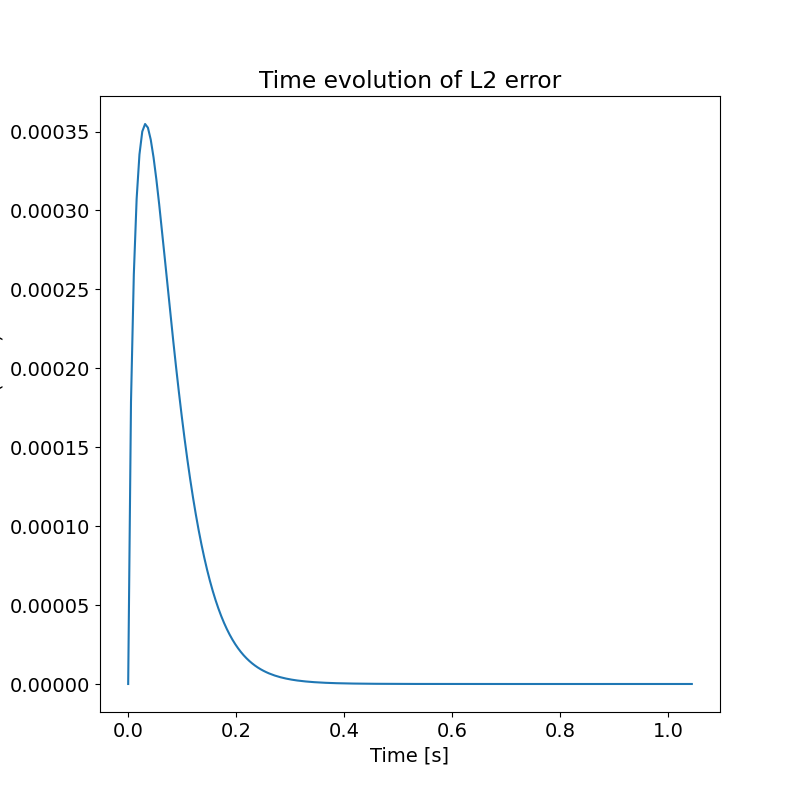

In [8]:

dens0 = dens.where(mask) - np.nanmean(dens.where(mask), axis=(1,2), keepdims=True)
true0 = dens_true.where(mask) - np.nanmean(dens_true.where(mask), axis=(1,2), keepdims=True)
dens_diff0 = np.abs(dens0 - true0)

dens_diff = np.abs(dens.where(mask) - dens_true.where(mask))
l2_err_t = np.sqrt(np.nanmean(dens_diff**2, axis=(1, 2)))
l2_err_n_t = np.sqrt(np.nanmean(dens_diff0**2, axis=(1, 2)))

print("Dirichlet Linf int err: " + str(np.max(l2_err_t)))
print("Dirichlet L2 int err (early): "   + str(l2_err_t[timestep_for_errs_early]))
print("Dirichlet L2 int err (late): "   + str(l2_err_t[timestep_for_errs_late]))

print("Neumann Linf int err: " + str(np.max(l2_err_n_t)))
print("Neumann L2 int err (early): "   + str(l2_err_n_t[timestep_for_errs_early]))
print("Neumann L2 int err (late): "   + str(l2_err_n_t[timestep_for_errs_late]))

#l2_err = np.sqrt(np.nanmean(dens_diff[100,:,:]**2))
#l2_unnorm = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz)
#l2_rel = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz) / np.sqrt(np.nansum(dens_true[100,:,:]**2)*dx*dz)
#print("L2 (RMS): "    + str(l2_err))
#print("L2 (unnorm): " + str(l2_unnorm))
#print("L2 (rel): "    + str(l2_rel))
#
true = dens_true.values[1:10, len(x)//2, len(z)//2] - dens_true.values[0, len(x)//2, len(z)//2]
sim = dens.values[1:10, len(x)//2, len(z)//2] - dens.values[0, len(x)//2, len(z)//2]
#print(*np.abs(sim-true), sep="\n")

init_dens_diff = dens_diff[0,:,:]
mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
nerrs = int(mask2.sum().compute())

ii, jj = np.where(mask2)

if nerrs > 0:
    print(init_dens_diff.values[ii[0],jj[0]])
    print(dens.values[0,ii[0],jj[0]])
    print(dens_true.values[0,ii[0],jj[0]])

print(nerrs)

plt.plot(t_norm, l2_err_n_t)
plt.xlabel("Time [s]")
plt.ylabel("L2 error (RMS)")
plt.title("Time evolution of L2 error")
plt.show()


Observed orders (p) between refinements:
  Boundary L2 (early) : p12=1.782, p23=0.923, avg=1.121
  Boundary L2 (half)  : p12=4.357, p23=1.123, avg=2.078
  Interior L2 (early) : p12=0.932, p23=1.055, avg=0.940
  Interior L2 (half)  : p12=1.790, p23=3.474, avg=1.410
  Boundary L∞         : p12=1.672, p23=0.328, avg=0.968
  Interior L∞         : p12=0.919, p23=1.058, avg=0.940


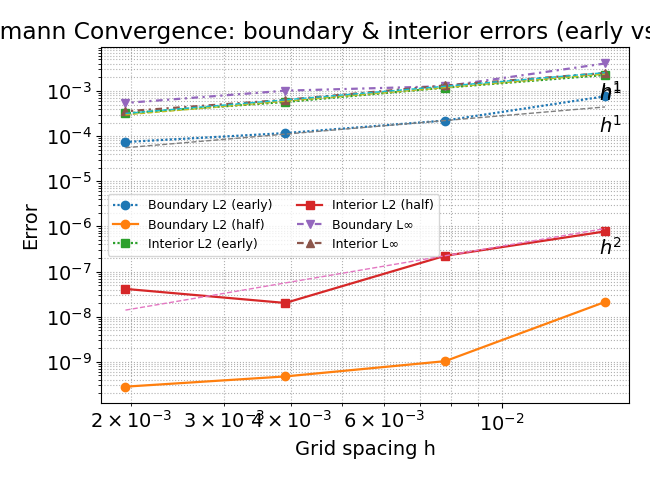

In [9]:
# convegence_plot.py
# Usage: fill in the error arrays below and run:  python convergence_plot.py

import numpy as np
import matplotlib.pyplot as plt

# --- Grid spacings (you can scale by your base h0 if you want) ---
h0 = 1/64               # set to your base h if you care about absolute values
h = np.array([h0, h0/2, h0/4, h0/8], dtype=float)

# ========================= FILL THESE IN =========================
# L2 @ EARLY time (transients present)

# t=10 fairly transient-y
E_b_L2_early = np.array([0.0007614422345874575, 0.00022134669389966248, 0.0001167368247471982, 7.405971284324232e-05])
E_i_L2_early = np.array([0.002258484797144969, 0.001184028464791716, 0.0005700488275431298, 0.00031966321593119223])

# L2 @ HALF simulation time (transients gone, your current metric)
E_b_L2_half  = np.array([2.124634435543955e-08, 1.0368070817132756e-09, 4.760496575081137e-10, 2.824247866469278e-10])
E_i_L2_half  = np.array([7.751504415079173e-07, 2.2410196528178145e-07, 2.01724383212586e-08,  4.130755835812756e-08])

# L∞ (single time of your choice—keep as what you were using before)
E_b_Linf     = np.array([0.004061576219392557,  0.0012744716598783506, 0.0010151850614995381, 0.0005423308360409245])
E_i_Linf     = np.array([0.0025049424048213223, 0.0013245290021628865, 0.0006359618958384586, 0.0003547809414421502])
# =================================================================

series = {
    # L2 (two times)
    "Boundary L2 (early)" : E_b_L2_early,
    "Boundary L2 (half)"  : E_b_L2_half,
    "Interior L2 (early)" : E_i_L2_early,
    "Interior L2 (half)"  : E_i_L2_half,
    # L∞
    "Boundary L∞"         : E_b_Linf,
    "Interior L∞"         : E_i_Linf,
}

def observed_order(h, e):
    return np.log(e[:-1]/e[1:]) / np.log(h[:-1]/h[1:])  # p between levels


def add_ref_slope(ax, x_anchor, y_anchor, p, xspan, where="right", offset=(-4, -6)):
    """
    Draw a dashed reference line of slope p through (x_anchor, y_anchor)
    over xspan=(xmin, xmax) on log-log axes, and label it near one end.

    where: "left", "right", or "center"
    offset: (dx, dy) text offset in screen points from the chosen anchor
    """
    x_ref = np.array(xspan, dtype=float)
    y_ref = y_anchor * (x_ref / x_anchor)**p
    ax.loglog(x_ref, y_ref, linestyle='--', linewidth=1.0)

    if where == "left":
        xlab = min(xspan)
    elif where == "right":
        xlab = max(xspan)
    else:  # center (geometric)
        xlab = np.sqrt(xspan[0] * xspan[1])

    ylab = y_anchor * (xlab / x_anchor)**p

    # Nice MathText label; change to f"h^{p:g}" if you prefer plain text
    label = rf"$h^{{{p:g}}}$"

    ax.annotate(
        label,
        xy=(xlab, ylab),
        xytext=offset, textcoords="offset points",
        ha="right" if where == "left" else ("left" if where == "right" else "center"),
        va="top"
    )

# --- Print observed orders ---
print("Observed orders (p) between refinements:")
for name, e in series.items():
    p = observed_order(h, e)
    print(f"  {name:20s}: p12={p[0]:.3f}, p23={p[1]:.3f}, avg={p.mean():.3f}")

# --- Plot ---
fig, ax = plt.subplots(figsize=(6.5, 4.8))

# Use distinct linestyles for time separation on L2 series
linestyles = {
    "Boundary L2 (early)": (0, (1, 1)),
    "Boundary L2 (half)" : "-",
    "Interior L2 (early)": (0, (1, 1)),
    "Interior L2 (half)" : "-",
    "Boundary L∞"        : (0, (3, 2, 1, 2)),
    "Interior L∞"        : (0, (3, 2, 1, 2)),
}

markers = {
    "Boundary L2 (early)": "o",
    "Boundary L2 (half)" : "o",
    "Interior L2 (early)": "s",
    "Interior L2 (half)" : "s",
    "Boundary L∞"        : "v",
    "Interior L∞"        : "^",
}

for name, e in series.items():
    ax.loglog(h, e, marker=markers[name], linewidth=1.6,
              linestyle=linestyles[name], label=name)

ax.set_xlabel("Grid spacing h")
ax.set_ylabel("Error")
ax.set_title("Neumann Convergence: boundary & interior errors (early vs half-time)")
ax.grid(True, which='both', ls=':')

# Optional: reference slopes (set to your expected rates)
# Example shows p=2 as a general reference drawn near midpoints of the L2(half) curves
ref_p = 2.0
x_anchor = h[1]
y_anchor = E_i_L2_half[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ref_p = 1.0
x_anchor = h[1]
y_anchor = E_b_L2_early[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ref_p = 1.0
x_anchor = h[1]
y_anchor = E_i_L2_early[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ref_p = 1.0
x_anchor = h[1]
y_anchor = E_b_Linf[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


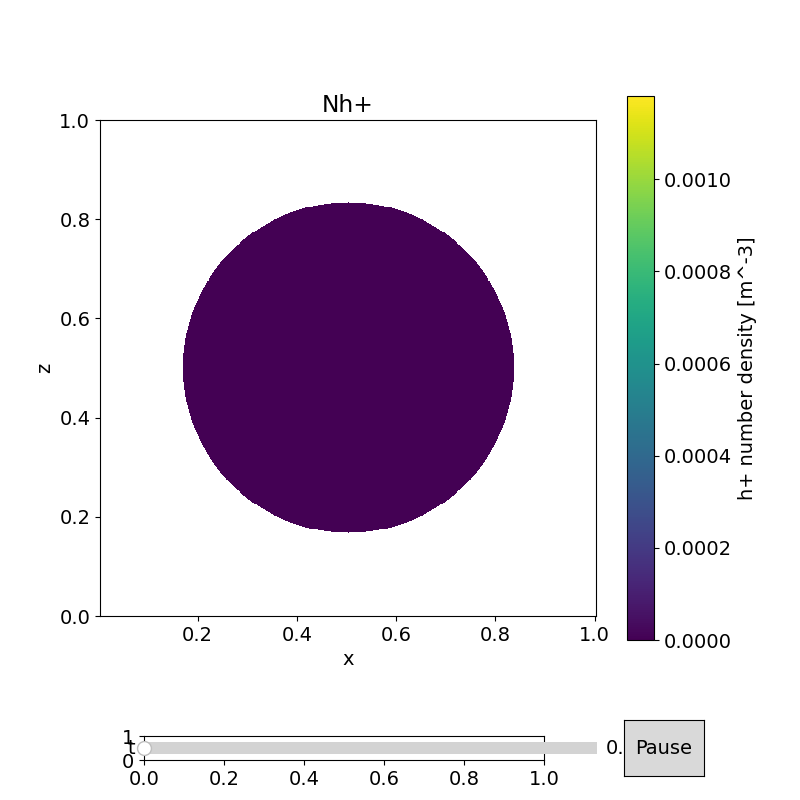

In [10]:
dens_diff0.bout.animate2D(aspect='equal')


Measured slope = -1.980815e+01  (expected -D*alpha1^2)
Expected slope = -2.642755e+01
Ratio (measured/expected) = 0.750


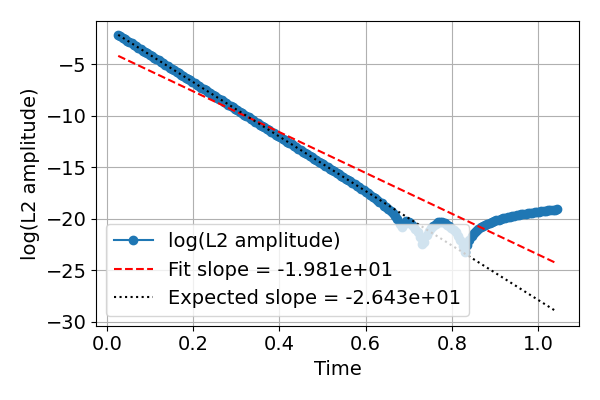

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# dens: shape (nt, nx, nz)
# time: shape (nt,)
# dx, dz: scalar cell sizes (uniform grid)
# If nonuniform, use cell area weights instead of dx*dz.

area = dx * dz
# Compute L2 amplitude (norm of mean-free component)
amp = np.sqrt(np.nansum(dens0.where(mask)**2, axis=(1, 2)) * area)

# Take the natural log of amplitude
logA = np.log(amp)

# Choose a time window where the decay is clean (exclude t=0 if noisy)
t_fit = t_norm[5:]       # skip a few early points if needed
logA_fit = logA[5:]

# Linear fit: log(A) = a + b * t
coeffs = np.polyfit(t_fit, logA_fit, 1)
slope, intercept = coeffs[0], coeffs[1]

print(f"Measured slope = {slope:.6e}  (expected -D*alpha1^2)")

# Example for first root of J1
from scipy.special import jn_zeros
alpha1 = jn_zeros(1, 1)[0]  # ~3.8317 for J1's first root

expected_slope = -D * alpha1**2/a**2
print(f"Expected slope = {expected_slope:.6e}")
print(f"Ratio (measured/expected) = {slope / expected_slope:.3f}")

plt.figure(figsize=(6,4))
plt.plot(t_fit, logA_fit, 'o-', label='log(L2 amplitude)')
plt.plot(t_fit, intercept + slope*t_fit, 'r--', label=f'Fit slope = {slope:.3e}')
plt.plot(t_fit, np.log(amp[0]) + expected_slope*t_fit, 'k:', 
         label=f'Expected slope = {expected_slope:.3e}')
plt.xlabel('Time')
plt.ylabel('log(L2 amplitude)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [12]:
print(dens.values[0,len(x)//2, len(z)//2])
print(dens.values[1,len(x)//2, len(z)//2])
print(dens_true.values[1,len(x)//2, len(z)//2])

print(dens0.values[0,len(x)//2, len(z)//2])
print(dens0.values[1,len(x)//2, len(z)//2])
print(true0.values[1,len(x)//2, len(z)//2])

1.0
0.8711480665945855
0.8711443118813147
0.999932708760165
0.870975654023026
0.8710856915011941
